##### Copyright 2025 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# [Gemma_3] Visual Document Extraction and JSON Parsing
By Sheshank Singh (@YourGitHubHandle)

This tutorial demonstrates how to leverage **Gemma 3 4B-IT**'s native multimodal capabilities to perform zero-shot data extraction from document images.

### **Hardware Requirements**
For optimal performance, this notebook requires an **NVIDIA T4 GPU** or higher. We use `bfloat16` precision to fit the model within 16GB of VRAM.

The code is intended to be readable, extensible, and suitable for open-source
cookbook or reference implementations.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google-gemini/gemma-cookbook/blob/main/Gemma/[Gemma_3]Visual_Document_Extraction.ipynb)

In [ ]:
# Install core dependencies for multimodal inference
!pip install -U transformers accelerate pillow torch -q

## Imports and authentication

In [ ]:
import torch
import json
from PIL import Image
from transformers import pipeline
from huggingface_hub import login

# Google Cloud/Colab users should store their token in 'Secrets'
login()

## Model initialization

The Gemma 3 4B-IT model is loaded using the `image-text-to-text` pipeline.

Design choices:
- `device_map="auto"` for flexible CPU/GPU placement
- `bfloat16` for reduced memory usage with stable numeric range
- No custom wrappers to keep behavior transparent


In [ ]:
def initialize_gemma_pipeline():
    """Initializes the Gemma 3 multimodal pipeline for vision-to-text tasks."""
    model_id = "google/gemma-3-4b-it"

    # Load with bfloat16 for memory efficiency and automatic device mapping
    # SigLIP encoder processes images as 256 soft tokens
    pipe = pipeline(
        "image-text-to-text",
        model=model_id,
        device_map="auto",
        torch_dtype=torch.bfloat16
    )
    return pipe

gemma_pipe = initialize_gemma_pipeline()

## Deterministic generation configuration

Inference is configured to be fully deterministic to ensure:
- Reproducibility across runs
- Stable behavior across library updates
- Easier debugging and evaluation


In [9]:
GENERATION_CONFIG = {
    "max_new_tokens": 512,
    "do_sample": False,
    "temperature": 0.0,
}

## Utility functions

These helpers isolate I/O and prompt construction logic from model inference.
This improves readability, testability, and maintainability.


In [10]:
def load_image(image_path: str) -> Image.Image:
    """
    Load an image from disk and convert to RGB.
    """
    try:
        return Image.open(image_path).convert("RGB")
    except Exception as e:
        raise RuntimeError(f"Failed to load image: {image_path}") from e

In [11]:
def build_prompt(schema: str) -> str:
    """
    Build a strict extraction prompt.
    """
    return (
        f"Act as a document intelligence assistant. Extract: {schema}. "
        "Return only a valid JSON object. No conversational filler."
    )

## Structured extraction

This function performs zero-shot structured extraction by:
1. Loading and validating the image
2. Constructing a strict extraction prompt
3. Running deterministic multimodal inference
4. Returning the raw model output

Parsing and validation are intentionally handled separately.


In [12]:
def extract_metadata(pipe, image_path: str, schema: str) -> str:
    """
    Perform zero-shot structured extraction from a document image.

    Args:
        pipe: Multimodal inference pipeline.
        image_path: Path to image file.
        schema: Comma-separated list of expected fields.

    Returns:
        Raw model output text.
    """
    image = load_image(image_path)
    prompt = build_prompt(schema)

    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": image},
                {"type": "text", "text": prompt},
            ],
        }
    ]

    output = pipe(text=messages, **GENERATION_CONFIG)
    return output[0]["generated_text"][-1]["content"]


## JSON parsing and schema validation

The parsing step:
- Removes optional markdown formatting
- Parses JSON strictly
- Enforces an explicit schema contract
- Fails fast on invalid outputs

This ensures downstream systems only receive well-formed data.


In [13]:
def parse_json_response(raw_text: str, expected_fields: set):
    """
    Parse and validate JSON returned by the model.

    Args:
        raw_text: Model output.
        expected_fields: Set of required JSON keys.

    Returns:
        dict with validated fields.
    """
    cleaned = raw_text.replace("```json", "").replace("```", "").strip()

    try:
        parsed = json.loads(cleaned)
    except json.JSONDecodeError as e:
        raise ValueError(f"Invalid JSON returned by model:\n{raw_text}") from e

    if set(parsed.keys()) != expected_fields:
        raise ValueError(
            f"Schema mismatch. Expected {expected_fields}, got {set(parsed.keys())}"
        )

    return parsed

## Example usage

The example below demonstrates invoice metadata extraction using a strict schema.


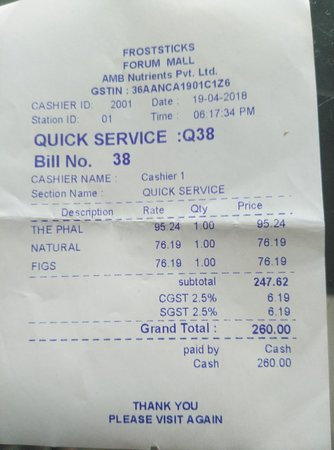

In [27]:
output_image = Image.open("/content/f68a46ae-d730-4c6f-82e4-05d79af3884d.png")
output_image

In [28]:
schema = "invoice_number, invoice_date, vendor_name, total_amount"
expected_fields = {
    "invoice_number",
    "invoice_date",
    "vendor_name",
    "total_amount",
}

raw_output = extract_metadata(
    pipe=gemma_pipe,
    image_path="/content/f68a46ae-d730-4c6f-82e4-05d79af3884d.png",
    schema=schema,
)

result = parse_json_response(raw_output, expected_fields)
result

{'invoice_number': '38',
 'invoice_date': '19-04-2018',
 'vendor_name': 'FROSTSTICKS FORUM MALL',
 'total_amount': '260.00'}